In [1]:
!pip install gower
import gower
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

  Created wheel for gower: filename=gower-0.0.5-py3-none-any.whl size=4232 sha256=95115d2ea56315a1f93fbdf50cd70a61d14cccb9ca40baa92cb29f3fd2cf052f
  Stored in directory: /home/lewinter.r/.cache/pip/wheels/0e/4a/62/f296d39ee4f9ffc44a8d44413dc8ce99ed022c581352312c20
Successfully built gower


# TSNE with Gower Matrix

This notebook is intended to be used on the Discovery cluster. The Gower matrix is too large to compute and use on our laptops, once computed on Colab the matrix takes up 4.3 GB in pickle format. Generating embeddings with this matrix goes beyond the Colab RAM allotment, so we'll have to do this on Discovery.

Load data:

In [2]:
X = pd.read_pickle('./data/unlabeled_behavior.pkl')
y_LinearSVC = pd.read_pickle('./data/y_pred_LinearSVC.pkl')
y_LogReg = pd.read_pickle('./data/y_pred_LogReg.pkl')
y_RidgeReg = pd.read_pickle('./data/y_pred_RidgeReg.pkl')

Compute the Gower matrix:

In [3]:
X_gower = pd.DataFrame(gower.gower_matrix(X, cat_features=[False, False, False, False, True,
                                                           False, False, False, True]))

Define the plotting function:

In [4]:
# plot_with_ys(x1, x2, y_class, y_cluster=None)
# Generates a 2d plot of the given data. If only y_class is given, data points will be colored by
# classification. If y_cluster is also given, data points will be colored by cluster label with shapes
# corresponding to classification. Intended for use with embeddings generated by TSNE. Plots with
# extended names will go to a scratch folder so we can compare selections of parameters for TSNE.
# Once we've chosen parameters these will be used through all future plots so the plots that go
# into our report can go without extended names.
# Variables:
# x1        -  array representing the position on the x-axis of each point in a 2d embedding from TSNE
# x2        -  array representing the position on the y-axis of each point in a 2d embedding from TSNE
# names     -  an array of string names for the classification algorithm used (index 0) and
#              the clustering algorithm used (index 1). If ext_names=True, also includes the 
#              perplexity (index 2) and the distance metric (index 3). For use in plotting.
# y_class   -  an array of classifications from a supervised model
# y_cluster -  an array of cluster labelings (default: None)
# ext_names -  whether to look for extended names for the plot (default: False)
@mpl.rc_context({'image.cmap': 'tab10', 'figure.figsize': [12.0, 8.0]})
def plot_with_ys(x1, x2, names, y_class, y_cluster=None, ext_names=False):
    
    fig, ax = plt.subplots()
    
    if y_cluster is not None: #plotting comparison between classification and clustering
        
        #create a colormap of the correct size, doing this bc just giving 'tab10' to the cmap
        #parameter gives colors from each end of the palette instead of sequentially
        colors = mpl.colors.ListedColormap(plt.get_cmap('tab10')(np.arange(len(np.unique(y_cluster)))))
        
        #plot the two predicted classes with different markers, coloring by cluster assignment
        x1_normal = [a for a,b in zip(x1, y_class) if b == 0]
        x2_normal = [a for a,b in zip(x2, y_class) if b == 0]
        scatter1 = ax.scatter(x1_normal, x2_normal, marker='|', cmap=colors,
                              c=y_cluster[np.argwhere(y_class == 0)])
        
        x1_outlier = [a for a,b in zip(x1, y_class) if b == 1]
        x2_outlier = [a for a,b in zip(x2, y_class) if b == 1]
        scatter2 = ax.scatter(x1_outlier, x2_outlier, marker='_', cmap=colors,
                              c=y_cluster[np.argwhere(y_class == 1)])
        
        #create a legend for differentiating between colors
        legend1 = ax.legend(*scatter1.legend_elements(), loc="lower left", title="Clusters")
        ax.add_artist(legend1)
        
        #create a legend from scratch for differentiating between markers
        vline = mlines.Line2D([], [], color='black', marker='|', linestyle='None',
                              markersize=10, label='0 (normal)')
        hline = mlines.Line2D([], [], color='black', marker='_', linestyle='None',
                              markersize=10, label='1 (outlier)')
        legend2 = ax.legend(handles=[vline, hline], loc="lower right", title="Classes")
        
        #insert given names to title and filename
        if ext_names: #with names for perplexity and distance metric
            plt.title('TSNE '+names[1]+' Clusterings & ' +names[0]+' Classifications p'
                      +names[2]+' '+names[3])
            filename = './figures/scratch/TSNE_'+names[1]+'_'+names[0]+'_p'+names[2]+'_'+names[3]+'.png'
        else: #without names for perplexity and distance metric
            plt.title('TSNE '+names[1]+' Clusterings & ' +names[0]+' Classifications')
            filename = './figures/TSNE_'+names[1]+'_'+names[0]+'.png'

        plt.savefig(filename, format='png')
    else: #plotting only a classification
        colors = mpl.colors.ListedColormap(plt.get_cmap('tab10')(np.arange(2)))
        scatter = ax.scatter(x1, x2, marker='.', c=y_class, cmap=colors)
        legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
        
        #insert given names to title and filename
        if ext_names: #with names for perplexity and distance metric
            plt.title('TSNE '+names[0]+' Classifications p'+names[2]+' '+names[3])
            filename = './figures/scratch/TSNE_'+names[0]+'_p'+names[2]+'_'+names[3]+'.png'
        else: #without names for perplexity and distance metric
            plt.title('TSNE '+names[0]+' Classifications')
            filename = './figures/TSNE_'+names[0]+'.png'
            
        plt.savefig(filename, format='png')

    plt.show()

Generate embeddings with TSNE and plot them with the supervised classifications:

In [7]:
%%capture

perplexities = np.arange(5, 70, 10)

for p in perplexities:
    
    #apply TSNE with Gower distance
    model = TSNE(n_components=2, perplexity=p, learning_rate='auto', metric='precomputed',
                 init='random', method='barnes_hut', square_distances=True, n_jobs=-1)
    X_new = model.fit_transform(X_gower)
    plot_with_ys(X_new[:,0], X_new[:,1], ['LinearSVC', None, str(p), 'Gower'],
                 y_LinearSVC, ext_names=True)
    plot_with_ys(X_new[:,0], X_new[:,1], ['LogReg', None, str(p), 'Gower'],
                 y_LogReg, ext_names=True)
    plot_with_ys(X_new[:,0], X_new[:,1], ['RidgeReg', None, str(p), 'Gower'],
                 y_RidgeReg, ext_names=True)

It turns out that from all of our parameter combinations, the best TSNE output came with Gower distance and perplexity=45, so let's generate final plots with these settings and save the embedding.

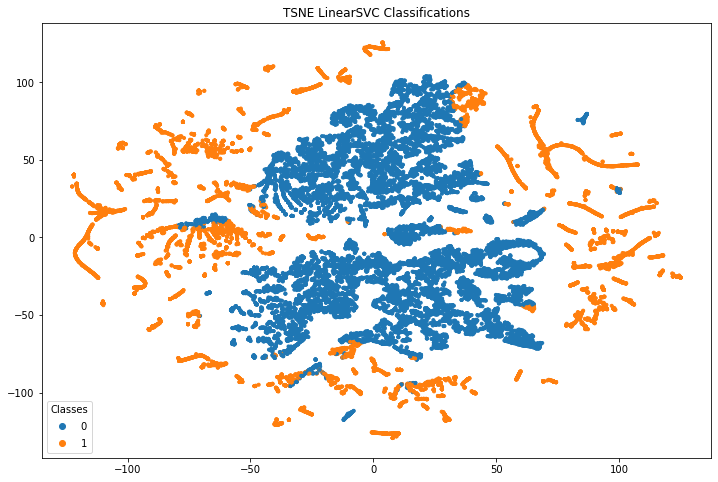

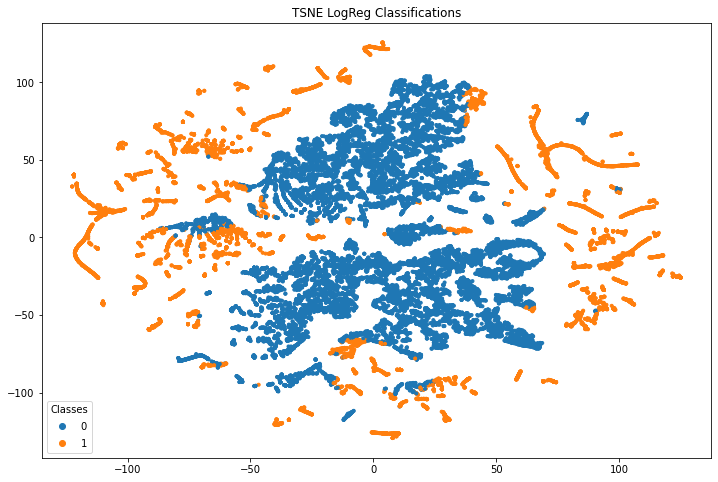

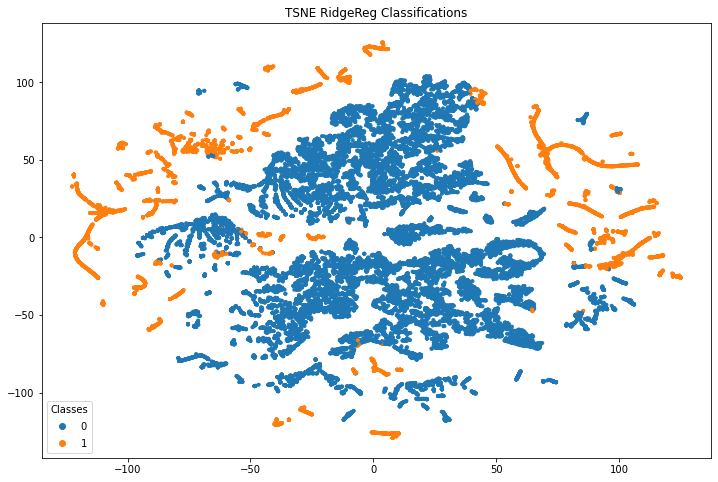

In [9]:
model = TSNE(n_components=2, perplexity=45, learning_rate='auto', metric='precomputed',
             init='random', method='barnes_hut', square_distances=True, n_jobs=-1)
X_new = model.fit_transform(X_gower)
plot_with_ys(X_new[:,0], X_new[:,1], ['LinearSVC'], y_LinearSVC)
plot_with_ys(X_new[:,0], X_new[:,1], ['LogReg'], y_LogReg)
plot_with_ys(X_new[:,0], X_new[:,1], ['RidgeReg'], y_RidgeReg)

In [10]:
pd.DataFrame(X_new).to_pickle('./data/embedding.pkl')